# DO NOT EDIT HERE! CLONE TO YOUR PERSONAL WORKSPACE

We can see who edits / changes / deletes.


In [0]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
import os, time
from pyspark import SparkContext
from pyspark.sql import SparkSession
import re
from pyspark.sql.window import Window 
from pyspark.sql import SparkSession 
from pyspark.sql.functions import split, explode, count, avg, col, when
 
spark = SparkSession.builder.appName("my_project_2").getOrCreate()
sc = spark.sparkContext 

# Read Sub Demographic data

In [0]:
demographic_df = spark.read.parquet("/dbfs/mnt/coursedata2024/fwm-stb-data/Project2_demographic.parquet")
demographic_df.printSchema()
display(demographic_df.limit(10))

root
 |-- household_id: string (nullable = true)
 |-- household_size: integer (nullable = true)
 |-- num_adults: integer (nullable = true)
 |-- num_generations: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- race_code: string (nullable = true)
 |-- dwelling_type: string (nullable = true)
 |-- home_owner_status: string (nullable = true)
 |-- length_residence: integer (nullable = true)
 |-- home_market_value: integer (nullable = true)
 |-- net_worth: integer (nullable = true)
 |-- education_highest: integer (nullable = true)
 |-- gender_individual: string (nullable = true)



household_id,household_size,num_adults,num_generations,marital_status,race_code,dwelling_type,home_owner_status,length_residence,home_market_value,net_worth,education_highest,gender_individual
00000015,2,2,1,S,B,S,O,5,5,6,4,M
00000028,3,2,2,S,W,S,O,3,8,5,2,M
00000056,2,2,1,S,W,S,O,4,10,5,1,M
00000061,2,2,2,M,W,S,O,15,8,8,1,M
00000098,3,2,2,M,W,S,O,4,13,7,1,F
00000111,2,2,1,S,W,S,O,15,4,8,2,M
00000122,3,2,2,M,W,S,O,8,7,7,2,F
00000130,2,2,2,S,W,S,O,8,8,6,2,M
00000145,1,1,1,B,W,S,O,3,6,5,1,M
00000160,2,2,1,A,W,S,O,15,6,6,1,M


# Read Static Viewing Data

In [0]:
static_viewing_df = spark.read.parquet("/dbfs/mnt/coursedata2024/fwm-stb-data/Project2_static_viewing_data.parquet")
static_viewing_df.printSchema()
display(static_viewing_df.limit(10))

root
 |-- device_id: string (nullable = true)
 |-- event_date: integer (nullable = true)
 |-- event_time: integer (nullable = true)
 |-- station_num: string (nullable = true)
 |-- prog_code: string (nullable = true)
 |-- household_id: long (nullable = true)



device_id,event_date,event_time,station_num,prog_code,household_id
000000d8b042,20151101,500,31709,EP015686040014,1463331
000000fb0fe7,20151101,230000,11006,EP001151270249,1447701
0000010e4717,20151101,13000,49788,EP003267331348,1447541
0000015ce10e,20151101,153432,50001,EP013605340004,2880783
000004351a40,20151101,65207,59636,SP003189620000,2882159
000004d26feb,20151101,210550,14988,MV002161540000,405836
000005ac0b7c,20151101,194211,63322,EP015662900055,397950
000013fb3e40,20151101,123000,16374,SH006818540000,399721
00001602e18b,20151101,64445,18090,SP003189620000,400046
000002c427cf,20151101,52403,59337,MV002415180000,1300668


# Static Data Analysis

## Feature Extraction

In [0]:

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import max, lit, min
from pyspark.ml.feature import VectorAssembler



column_order = [
    'household_id', 'household_size', 'num_adults', 'num_generations',
    'marital_status', 'race_code', 'dwelling_type', 'home_owner_status',
    'length_residence', 'home_market_value', 'net_worth', 'education_highest',
    'gender_individual'
]

categorical_columns_list=['marital_status','race_code','dwelling_type','home_owner_status','gender_individual' ,'education_highest']

indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_index") for c in categorical_columns_list]
encoders = [OneHotEncoder(inputCol=f"{c}_index", outputCol=f"{c}_ohe") for c in categorical_columns_list]
pipeline = Pipeline(stages=indexers + encoders)
model = pipeline.fit(demographic_df)
demographic_df_encoded = model.transform(demographic_df) 

# Drop index + original categorical_columns_list columns
columns_to_drop = categorical_columns_list + [f"{c}_index" for c in categorical_columns_list]
demographic_df_encoded = demographic_df_encoded.drop(*columns_to_drop)

for categorical_column in categorical_columns_list:
    demographic_df_encoded = demographic_df_encoded.withColumnRenamed(f"{categorical_column}_ohe", categorical_column)


demographic_df_encoded = demographic_df_encoded.select(column_order)

columns_to_normalize = ['num_generations', 'household_size', 'num_adults' ,'num_generations', 'length_residence', 'home_market_value', 'net_worth']

# Normalize each column
for column in columns_to_normalize:
    col_min = demographic_df_encoded.select(min(col(column))).collect()[0][0]
    col_max = demographic_df_encoded.select(max(col(column))).collect()[0][0]
    
    demographic_df_encoded = demographic_df_encoded.withColumn(
        column,
        (col(column) - lit(col_min)) / (lit(col_max) - lit(col_min))
    )

all_feature_columns = [
    'household_size', 'num_adults', 'num_generations',
    'marital_status', 'race_code', 'dwelling_type', 'home_owner_status',
    'length_residence', 'home_market_value', 'net_worth', 'education_highest',
    'gender_individual'
]

# Create the VectorAssembler
assembler = VectorAssembler(inputCols=all_feature_columns, outputCol='features')
# Apply the VectorAssembler to the DataFrame
demographic_df_features = assembler.transform(demographic_df_encoded)
# Show the result

demographic_df_features=demographic_df_features.select('household_id', 'features')

display(demographic_df_features.limit(10)) 


household_id,features
00000015,"Map(vectorType -> sparse, length -> 18, indices -> List(0, 1, 4, 8, 9, 10, 11, 12, 13, 17), values -> List(0.125, 0.2, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.2222222222222222, 0.625, 1.0))"
00000028,"Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.2, 0.3888888888888889, 0.5, 0.0, 1.0, 0.0, 1.0))"
00000056,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.26666666666666666, 0.5, 0.5, 1.0, 0.0, 0.0, 1.0))"
00000061,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.5, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.3888888888888889, 0.875, 1.0, 0.0, 0.0, 1.0))"
00000098,"Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.26666666666666666, 0.6666666666666666, 0.75, 1.0, 0.0, 0.0, 0.0))"
00000111,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.16666666666666666, 0.875, 0.0, 1.0, 0.0, 1.0))"
00000122,"Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.5333333333333333, 0.3333333333333333, 0.75, 0.0, 1.0, 0.0, 0.0))"
00000130,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.5, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.5333333333333333, 0.3888888888888889, 0.625, 0.0, 1.0, 0.0, 1.0))"
00000145,"Map(vectorType -> sparse, length -> 18, indices -> List(6, 9, 10, 11, 12, 13, 14, 17), values -> List(1.0, 1.0, 1.0, 0.2, 0.2777777777777778, 0.5, 1.0, 1.0))"
00000160,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.2777777777777778, 0.625, 1.0, 0.0, 0.0, 1.0))"


## Visual Analysis

U1,U2
0.0014263569853200987,-1.3121794606841942E-4
0.001963066573937505,-0.0023556143971153166
0.0019729261760099526,0.0021418118888584777
0.0025308950997329814,0.0016550109723084006
0.0021285208200594683,0.0017194444049670374
0.0021540761383180298,-0.002530225122656659
0.0020764140365785843,-0.002862837748584345
0.0020758168805830634,-0.002404544252507549
0.001799037074747798,0.0020076778195649786
0.0021533996750691562,0.0020246410926667755


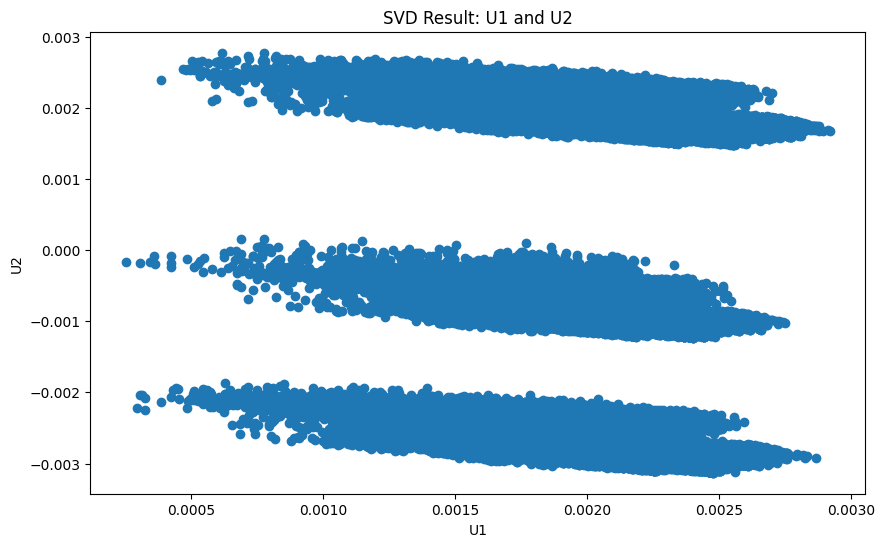

In [0]:
from pyspark.ml.linalg import Vectors as ML_Vectors
from pyspark.ml.recommendation import ALS
from pyspark.ml import Estimator
import matplotlib.pyplot as plt 
from pyspark.mllib.linalg import Vectors as MLLib_Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

# Convert the 'features' column to an RDD of MLLib Dense Vectors
features_rdd = demographic_df_features.select("features").rdd.map(lambda row: MLLib_Vectors.dense(row['features'].toArray()))

# Create a RowMatrix from the RDD
row_matrix = RowMatrix(features_rdd)

# Apply SVD with k=2
svd = row_matrix.computeSVD(2, computeU=True) 

# Extract U (the reduced data matrix)
U = svd.U

U_df = U.rows.map(lambda row: row.toArray().tolist()).toDF(['U1', 'U2']) 

display(U_df.limit(10))

U_pandas_df = U_df.toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(U_pandas_df['U1'], U_pandas_df['U2'])
plt.xlabel('U1')
plt.ylabel('U2')
plt.title('SVD Result: U1 and U2')
plt.show()


## Clustering

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors 
from pyspark.sql import SparkSession 
from pyspark.sql.types import FloatType 
import numpy as np
import pandas as pd

kmeans = KMeans(k=8, seed=7)  # k=8 for 8 clusters
model = kmeans.fit(demographic_df_features.select('features'))
demographic_df_with_clusters = model.transform(demographic_df_features)


# Define a UDF to calculate Euclidean distance between two vectors
def euclidean_distance(v1, v2):
    return float(sum((a - b) ** 2 for a, b in zip(v1, v2)) ** 0.5)

# Register the UDF
distance_udf = F.udf(euclidean_distance, FloatType())

# Get cluster centers as a DataFrame
centroids = model.clusterCenters()
centroids_df = spark.createDataFrame([(i, Vectors.dense(center)) for i, center in enumerate(centroids)], ["cluster", "centroid"])

# Join the original DataFrame with the centroids DataFrame on the cluster ID
demographic_df_with_centroids = demographic_df_with_clusters.join(
    centroids_df,
    demographic_df_with_clusters["prediction"] == centroids_df["cluster"],
    how="left"
).drop("prediction")

# Calculate the distance of each household from its centroid
demographic_df_with_distances = demographic_df_with_centroids.withColumn(
    "distance_from_centroid",
    distance_udf(demographic_df_with_centroids["features"], demographic_df_with_centroids["centroid"])
)

demographic_df_with_cluster_distances = demographic_df_with_distances.drop('centroid')

# Show the first few rows of the updated DataFrame
display(demographic_df_with_cluster_distances.limit(10))


household_id,features,cluster,distance_from_centroid
00000015,"Map(vectorType -> sparse, length -> 18, indices -> List(0, 1, 4, 8, 9, 10, 11, 12, 13, 17), values -> List(0.125, 0.2, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.2222222222222222, 0.625, 1.0))",7,1.5962042
00000028,"Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.2, 0.3888888888888889, 0.5, 0.0, 1.0, 0.0, 1.0))",3,0.891077
00000056,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.26666666666666666, 0.5, 0.5, 1.0, 0.0, 0.0, 1.0))",7,0.6265717
00000061,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.5, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.3888888888888889, 0.875, 1.0, 0.0, 0.0, 1.0))",4,0.67103696
00000098,"Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.26666666666666666, 0.6666666666666666, 0.75, 1.0, 0.0, 0.0, 0.0))",4,0.8198437
00000111,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.16666666666666666, 0.875, 0.0, 1.0, 0.0, 1.0))",3,0.9877135
00000122,"Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.5333333333333333, 0.3333333333333333, 0.75, 0.0, 1.0, 0.0, 0.0))",1,0.5903271
00000130,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.5, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.5333333333333333, 0.3888888888888889, 0.625, 0.0, 1.0, 0.0, 1.0))",3,0.79010713
00000145,"Map(vectorType -> sparse, length -> 18, indices -> List(6, 9, 10, 11, 12, 13, 14, 17), values -> List(1.0, 1.0, 1.0, 0.2, 0.2777777777777778, 0.5, 1.0, 1.0))",7,1.1815403
00000160,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.2777777777777778, 0.625, 1.0, 0.0, 0.0, 1.0))",6,0.7875541


## Visual Clustering

household_id,features,cluster,distance_from_centroid,pca_features
00000015,"Map(vectorType -> sparse, length -> 18, indices -> List(0, 1, 4, 8, 9, 10, 11, 12, 13, 17), values -> List(0.125, 0.2, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.2222222222222222, 0.625, 1.0))",7,1.5962042,"Map(vectorType -> dense, length -> 2, values -> List(0.016528050191287058, 0.28845561701937866))"
00000028,"Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.2, 0.3888888888888889, 0.5, 0.0, 1.0, 0.0, 1.0))",3,0.891077,"Map(vectorType -> dense, length -> 2, values -> List(0.6342950392969358, 0.11859832379395045))"
00000056,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.26666666666666666, 0.5, 0.5, 1.0, 0.0, 0.0, 1.0))",7,0.6265717,"Map(vectorType -> dense, length -> 2, values -> List(-0.7046423853877983, 0.3446035327993541))"
00000061,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.5, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.3888888888888889, 0.875, 1.0, 0.0, 0.0, 1.0))",4,0.67103696,"Map(vectorType -> dense, length -> 2, values -> List(-0.8847241848037346, -1.1281330273655297))"
00000098,"Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.26666666666666666, 0.6666666666666666, 0.75, 1.0, 0.0, 0.0, 0.0))",4,0.8198437,"Map(vectorType -> dense, length -> 2, values -> List(-0.8441889461861548, -0.9959542275393409))"
00000111,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.16666666666666666, 0.875, 0.0, 1.0, 0.0, 1.0))",3,0.9877135,"Map(vectorType -> dense, length -> 2, values -> List(0.6707992202123951, 0.08243155168511855))"
00000122,"Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.5333333333333333, 0.3333333333333333, 0.75, 0.0, 1.0, 0.0, 0.0))",1,0.5903271,"Map(vectorType -> dense, length -> 2, values -> List(0.5315436584922707, -1.1833884706237883))"
00000130,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.5, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.5333333333333333, 0.3888888888888889, 0.625, 0.0, 1.0, 0.0, 1.0))",3,0.79010713,"Map(vectorType -> dense, length -> 2, values -> List(0.6364690330304517, 0.08576723411089036))"
00000145,"Map(vectorType -> sparse, length -> 18, indices -> List(6, 9, 10, 11, 12, 13, 14, 17), values -> List(1.0, 1.0, 1.0, 0.2, 0.2777777777777778, 0.5, 1.0, 1.0))",7,1.1815403,"Map(vectorType -> dense, length -> 2, values -> List(-0.7554184968753976, -0.14933154081320277))"
00000160,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.2777777777777778, 0.625, 1.0, 0.0, 0.0, 1.0))",6,0.7875541,"Map(vectorType -> dense, length -> 2, values -> List(-0.7771180306932655, -0.1305254221510399))"


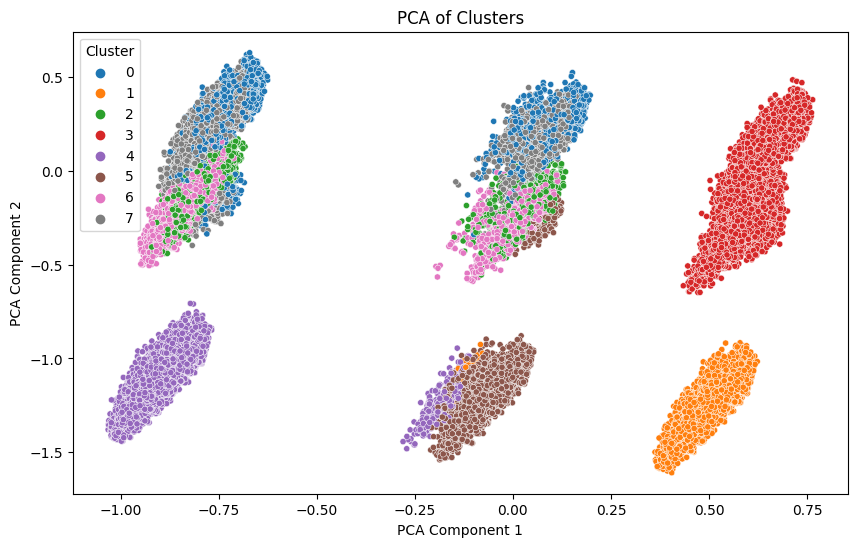

In [0]:
from pyspark.ml.feature import PCA
import seaborn as sns


# Apply PCA to reduce dimensions to 2
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(demographic_df_with_cluster_distances)
pca_result = pca_model.transform(demographic_df_with_cluster_distances)

display(pca_result.limit(10))

# Convert the Spark DataFrame to a Pandas DataFrame
pca_pdf = pca_result.select("household_id", "cluster", "distance_from_centroid", "pca_features").toPandas()

# Extract PCA features into separate columns
pca_features = pd.DataFrame(pca_pdf['pca_features'].tolist(), columns=['pca1', 'pca2'])
pca_pdf = pca_pdf.drop(columns=['pca_features'])
pca_pdf = pd.concat([pca_pdf, pca_features], axis=1)

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_pdf, x="pca1", y="pca2", hue="cluster", palette="tab10", marker='o', s=20)
plt.title('PCA of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


## Dividing households into subsets

In [0]:
from pyspark.sql import Window

window_spec = Window.partitionBy("cluster").orderBy("distance_from_centroid")

demographic_df_with_row_number = demographic_df_with_cluster_distances.withColumn(
    "row_number", F.row_number().over(window_spec) 
)

sevenths_subset = demographic_df_with_row_number.filter(
    (col("row_number") % 7) == 0
).drop("row_number")

eleven_subset = demographic_df_with_row_number.filter(
    (col("row_number") % 11) == 0 
).drop("row_number")



## Cluster’s Viewing Analysis

top-10 highest ’diff rank’ stations for sevenths_subset of cluster 0

station_num,cluster,view_count,diff_rank
14909,0,47646,0.23998536715555374
11158,0,62528,0.23303110415174644
11221,0,82527,0.19692876172662688
10918,0,55352,0.1837968006752747
10145,0,58651,0.17692508352332137
11069,0,45963,0.17505751445053724
11207,0,87081,0.1676250603379721
12574,0,64850,0.14709233072450212
11865,0,19548,0.13580302374413242
70387,0,42117,0.12723173934016047


top-10 highest ’diff rank’ stations for eleven_subset of cluster 0

station_num,cluster,view_count,diff_rank
12574,0,64850,0.3194540092739002
10171,0,105204,0.27635541393602625
74796,0,56727,0.2035101828136835
14909,0,47646,0.18605921215543608
11867,0,80921,0.18331098220597408
11221,0,82527,0.16742508056779726
10057,0,38611,0.1590233093815127
10918,0,55352,0.14635425573319938
11158,0,62528,0.14612903997242377
10366,0,10222,0.1339835231269351


top-10 highest ’diff rank’ stations for full data of cluster 0

station_num,cluster,view_count,diff_rank
11221,0,82527,0.26515784756355454
12574,0,64850,0.16221287847755705
11069,0,45963,0.16139411795012276
11207,0,87081,0.16088850532004106
16615,0,67846,0.1549643677242596
11158,0,62528,0.15465383308355662
10918,0,55352,0.15135275167392737
10171,0,105204,0.13100352534308435
14909,0,47646,0.12052821575483641
10145,0,58651,0.11485358461175488


top-10 highest ’diff rank’ stations for sevenths_subset of cluster 1

station_num,cluster,view_count,diff_rank
99993,1,800201,0.4201884182648392
60179,1,137138,0.4055575343551028
16374,1,142003,0.33719316520518716
49788,1,83291,0.1451285048598181
11221,1,82527,0.10701197025126774
32645,1,129320,0.0977775788291535
11066,1,59748,0.09410267771836567
42574,1,8404,0.0819192262208824
14765,1,48465,0.08166389162990106
30754,1,13202,0.07442385227556128


top-10 highest ’diff rank’ stations for eleven_subset of cluster 1

station_num,cluster,view_count,diff_rank
60179,1,137138,0.5624488941507193
16374,1,142003,0.3581989041527176
99993,1,800201,0.23227199929155518
32645,1,129320,0.1590081819291691
58646,1,58688,0.1348593779839018
49788,1,83291,0.1327091370804574
61854,1,23438,0.12254516613559976
45507,1,47483,0.10113231143783102
58780,1,22362,0.08445034553952027
11066,1,59748,0.08389681831981699


top-10 highest ’diff rank’ stations for full data of cluster 1

station_num,cluster,view_count,diff_rank
60179,1,137138,0.4306117783994501
99993,1,800201,0.3059144865883816
16374,1,142003,0.24820899737214908
49788,1,83291,0.1752142743023194
32645,1,129320,0.12707416570173535
31709,1,15075,0.0926331983785233
30754,1,13202,0.08874288938450517
61854,1,23438,0.07790634824876017
10335,1,15687,0.05954476565906752
21251,1,10293,0.055628009567022796


top-10 highest ’diff rank’ stations for sevenths_subset of cluster 2

station_num,cluster,view_count,diff_rank
60179,2,137138,0.45768803939039615
12131,2,103763,0.26947670955447056
11713,2,37241,0.1675840311719261
11006,2,24935,0.16601474537351057
99995,2,103330,0.1529807454984764
58646,2,58688,0.1466724480863184
11150,2,71803,0.14275566317683608
30468,2,3552,0.13848490242894035
49524,2,4087,0.13570912876267427
14776,2,25940,0.10071663936405001


top-10 highest ’diff rank’ stations for eleven_subset of cluster 2

station_num,cluster,view_count,diff_rank
99993,2,800201,0.3695630740229614
74796,2,56727,0.30810727227211354
60179,2,137138,0.2849299780671546
99995,2,103330,0.24293834883471765
25147,2,8016,0.18070121317735136
21250,2,9586,0.16905189014036914
10171,2,105204,0.16619428203017006
49788,2,83291,0.16564185813409282
14902,2,91332,0.1481912412724028
16300,2,49056,0.1278739399847828


top-10 highest ’diff rank’ stations for full data of cluster 2

station_num,cluster,view_count,diff_rank
60179,2,137138,0.24781473043340618
99995,2,103330,0.17157663126072276
14902,2,91332,0.11219794093417546
11713,2,37241,0.1080136502916435
10171,2,105204,0.1075320458359954
49788,2,83291,0.1046936816549956
19628,2,11453,0.09619161803277927
59684,2,46186,0.09574073233931074
21250,2,9586,0.06409507451573182
42574,2,8404,0.054477761740073974


top-10 highest ’diff rank’ stations for sevenths_subset of cluster 3

station_num,cluster,view_count,diff_rank
10171,3,105204,0.22579300026083193
59684,3,46186,0.12536082949759547
10559,3,20472,0.09627887345442698
15433,3,25543,0.0930567810137985
14909,3,47646,0.08925532257270508
58515,3,69083,0.07308586053733646
16374,3,142003,0.06940340168823744
12852,3,55152,0.06646048332098087
10057,3,38611,0.06489104842596621
10402,3,10083,0.06183872598534634


top-10 highest ’diff rank’ stations for eleven_subset of cluster 3

station_num,cluster,view_count,diff_rank
60179,3,137138,0.14264036805429203
15433,3,25543,0.12772132802113828
59684,3,46186,0.12350955305701278
58646,3,58688,0.11451891968782613
19616,3,6115,0.11012556360672465
49788,3,83291,0.10190264704747021
42642,3,49873,0.0996254225094444
12852,3,55152,0.09215855583216426
52237,3,2574,0.09201005118425822
66268,3,36575,0.08991894029852915


top-10 highest ’diff rank’ stations for full data of cluster 3

station_num,cluster,view_count,diff_rank
59684,3,46186,0.07881108823429744
49788,3,83291,0.06674931945599816
14902,3,91332,0.057699784780736896
58646,3,58688,0.05337670770514369
10142,3,90415,0.050125441656375225
99995,3,103330,0.04998666598333634
32645,3,129320,0.04749596943886436
10171,3,105204,0.04330302871589797
19628,3,11453,0.039794531939740516
15433,3,25543,0.0395080499389755


top-10 highest ’diff rank’ stations for sevenths_subset of cluster 4

station_num,cluster,view_count,diff_rank
60179,4,137138,0.1692756661723427
11187,4,89133,0.11647506322328383
14902,4,91332,0.07578398885539339
11896,4,6855,0.0680920258022775
32645,4,129320,0.06319446863551992
11458,4,10451,0.05777445918900989
30754,4,13202,0.05647983273291329
31316,4,8580,0.05568082077814669
31046,4,25564,0.0554789130178191
66268,4,36575,0.054882962452233175


top-10 highest ’diff rank’ stations for eleven_subset of cluster 4

station_num,cluster,view_count,diff_rank
99993,4,800201,0.13171315804647676
11865,4,19548,0.12960874306093076
14771,4,89195,0.11651328704117836
11150,4,71803,0.10032371675435159
25544,4,10795,0.09140614878198271
11187,4,89133,0.07046374414384537
14765,4,48465,0.06797447490494024
11458,4,10451,0.049194638423474185
19630,4,14707,0.047991516660074174
10179,4,92164,0.04729823735972105


top-10 highest ’diff rank’ stations for full data of cluster 4

station_num,cluster,view_count,diff_rank
99993,4,800201,0.15834907966517697
60179,4,137138,0.09755823010376674
31709,4,15075,0.08212409885621577
14765,4,48465,0.07269437990499217
30754,4,13202,0.06855659433358857
14771,4,89195,0.06814756842159264
14902,4,91332,0.05090943530501413
11458,4,10451,0.049435810701494276
25544,4,10795,0.04927544150991091
11865,4,19548,0.04760601274039075


top-10 highest ’diff rank’ stations for sevenths_subset of cluster 5

station_num,cluster,view_count,diff_rank
60179,5,137138,1.062393862229172
99993,5,800201,0.5792679397261207
49788,5,83291,0.4336551265465469
32645,5,129320,0.3950677979442694
16374,5,142003,0.37194160532073295
58646,5,58688,0.29605861340415895
64241,5,32727,0.2360045631919908
19628,5,11453,0.19369828387842475
45507,5,47483,0.17881143163221674
42574,5,8404,0.15604944509667767


top-10 highest ’diff rank’ stations for eleven_subset of cluster 5

station_num,cluster,view_count,diff_rank
99993,5,800201,0.882880312676626
60179,5,137138,0.8620332623830216
32645,5,129320,0.5629542091375781
49788,5,83291,0.49546062722527906
16374,5,142003,0.35955530479608533
58646,5,58688,0.2654575083448866
10142,5,90415,0.19306255928904825
31709,5,15075,0.16646155920826114
11765,5,24385,0.15611675058200492
45507,5,47483,0.1443624859417451


top-10 highest ’diff rank’ stations for full data of cluster 5

station_num,cluster,view_count,diff_rank
60179,5,137138,0.8595863306927292
99993,5,800201,0.462565107818083
16374,5,142003,0.44464077964588156
32645,5,129320,0.3243985972293433
49788,5,83291,0.3124260135828356
58646,5,58688,0.22480401801462058
64241,5,32727,0.18335147306145239
61854,5,23438,0.13946349065630895
14902,5,91332,0.1353668971421299
45507,5,47483,0.12147263503151745


top-10 highest ’diff rank’ stations for sevenths_subset of cluster 6

station_num,cluster,view_count,diff_rank
32645,6,129320,0.43911991718247756
60179,6,137138,0.3893432276365978
59684,6,46186,0.174961931313447
58646,6,58688,0.1595521406127387
45507,6,47483,0.15622771815138675
65732,6,27228,0.1518817434802044
99995,6,103330,0.1352451050956962
51529,6,36850,0.13149913161375032
64549,6,21983,0.12109575798984804
42574,6,8404,0.10779336727127013


top-10 highest ’diff rank’ stations for eleven_subset of cluster 6

station_num,cluster,view_count,diff_rank
16374,6,142003,0.2863000304494432
32645,6,129320,0.22775081578892475
11713,6,37241,0.1582601473160048
58646,6,58688,0.1523268403018514
12852,6,55152,0.14923366218218082
60179,6,137138,0.1250384202871886
59684,6,46186,0.1237121287634641
19626,6,5450,0.12057765705512422
51529,6,36850,0.1113679500578989
59036,6,11156,0.10855105029763858


top-10 highest ’diff rank’ stations for full data of cluster 6

station_num,cluster,view_count,diff_rank
32645,6,129320,0.3165559201961652
60179,6,137138,0.27102829861223654
99995,6,103330,0.1517902655298653
49788,6,83291,0.1244825077018622
59684,6,46186,0.1124539367667477
45507,6,47483,0.10222675450688484
82547,6,28692,0.07529623344908493
58646,6,58688,0.07350581971130332
50747,6,42169,0.06949581606159044
58515,6,69083,0.06927778146468422


top-10 highest ’diff rank’ stations for sevenths_subset of cluster 7

station_num,cluster,view_count,diff_rank
32645,7,129320,0.2252007623436243
56905,7,50119,0.17935947360762095
58515,7,69083,0.13307868219611296
59684,7,46186,0.13119737513800794
58452,7,26590,0.12663736493006733
65732,7,27228,0.12032652729298343
58574,7,36992,0.1193745785230047
42642,7,49873,0.11899128733315822
66379,7,25509,0.11734787778075989
12131,7,103763,0.10975498836705899


top-10 highest ’diff rank’ stations for eleven_subset of cluster 7

station_num,cluster,view_count,diff_rank
58646,7,58688,0.19952721889361924
60179,7,137138,0.19687147740005018
32645,7,129320,0.18927068477055875
10179,7,92164,0.17460301814668922
14771,7,89195,0.1682097816503061
11867,7,80921,0.1561792108158172
56905,7,50119,0.15465328641923248
16616,7,20997,0.14768491428177358
64241,7,32727,0.1456459101243502
10171,7,105204,0.13949024700885548


top-10 highest ’diff rank’ stations for full data of cluster 7

station_num,cluster,view_count,diff_rank
32645,7,129320,0.21339024879097535
58515,7,69083,0.1600880839704475
56905,7,50119,0.10284585607146968
64241,7,32727,0.08867153777792325
58574,7,36992,0.0885310647574496
65732,7,27228,0.0790625688218084
59337,7,39770,0.07555124125903073
60048,7,46216,0.0741358379922859
14771,7,89195,0.07237657852448554
18284,7,24984,0.07163986614392573


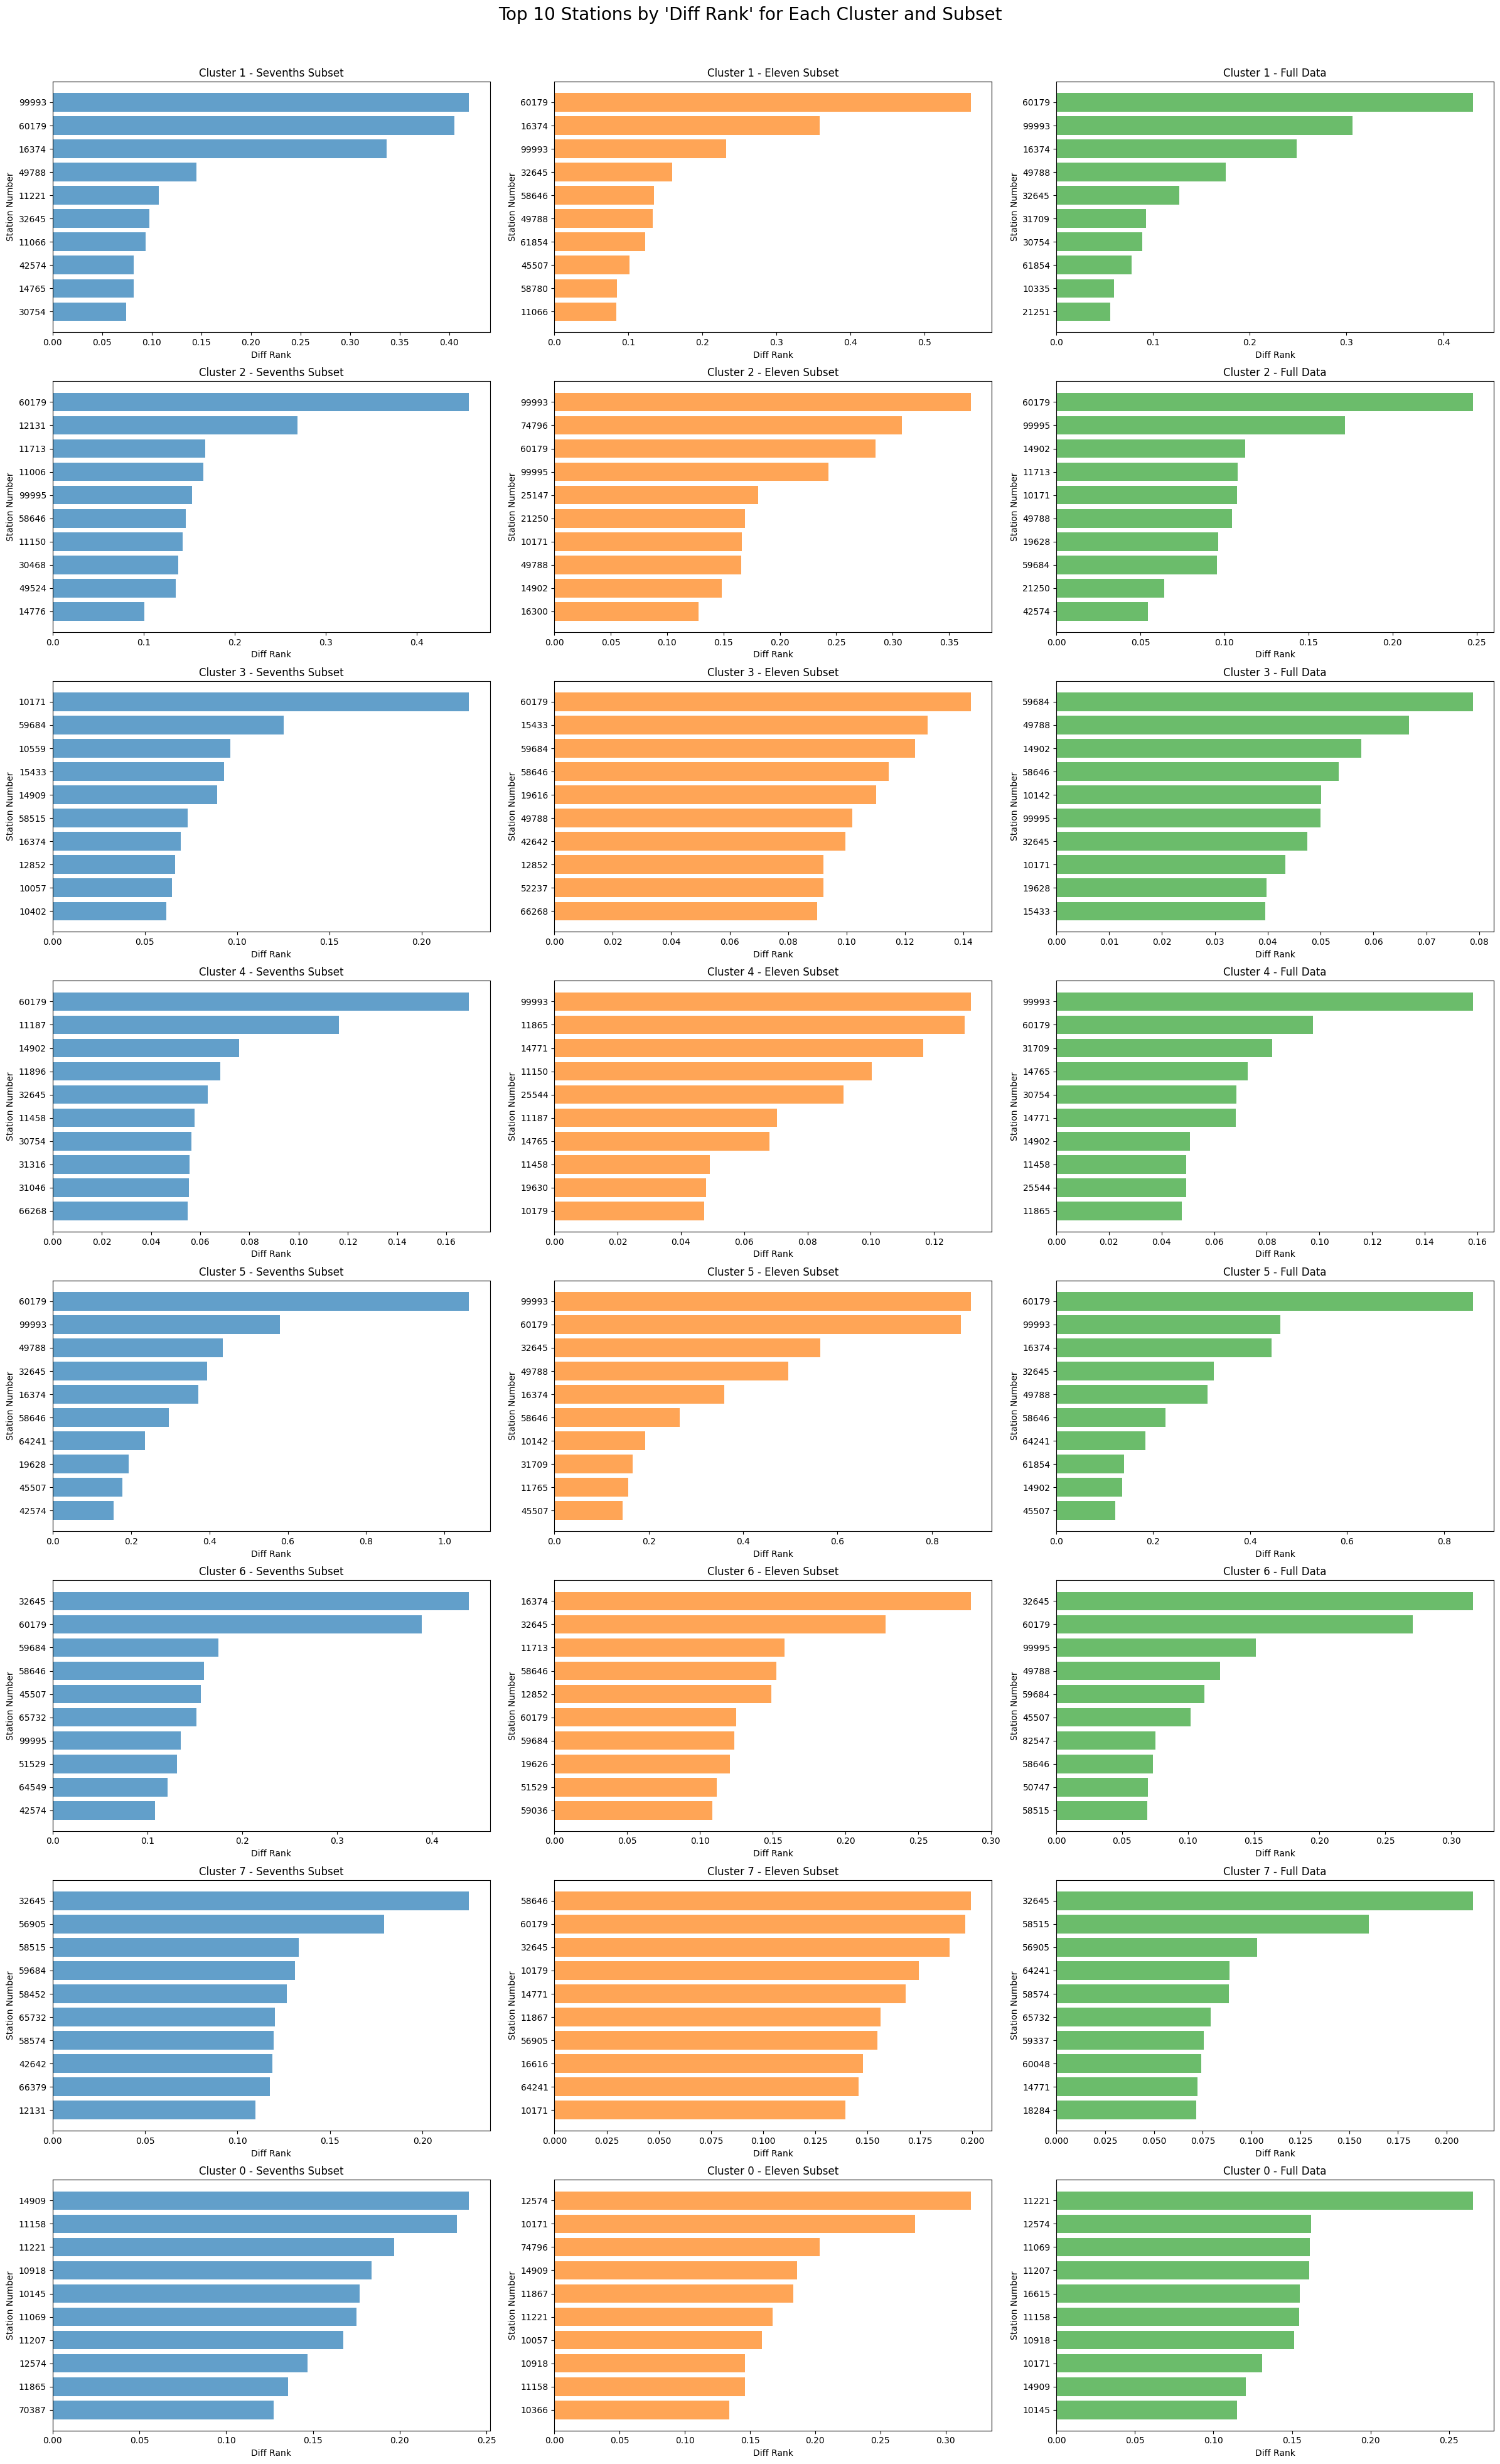

In [0]:

def add_viewing_counts_percent(input_df): 
    joined_df = input_df.join(static_viewing_df, on = 'household_id')
    viewing_counts_per_station = joined_df.groupBy('cluster', 'station_num').agg(F.count("*").alias("view_count"))

    viewing_counts_per_cluster = viewing_counts_per_station.groupBy('cluster').agg(F.sum('view_count').alias('view_count_cluster')) 

    viewing_counts_with_totals = viewing_counts_per_station.join( 
        viewing_counts_per_cluster,
        on='cluster', 
        how='inner'
    )
    viewing_counts_percent = viewing_counts_with_totals.withColumn( 
        'percent_view_count',
        (F.col('view_count') / F.col('view_count_cluster')) * 100
    )

    viewing_counts_percent = viewing_counts_percent.drop('view_count_cluster','view_count')
    return viewing_counts_percent 

viewing_counts_per_station = static_viewing_df.groupBy('station_num').agg(F.count("*").alias("view_count"))

total_viewing_counts = viewing_counts_per_station.agg(F.sum('view_count').alias('total_view_count')).collect()[0]['total_view_count'] 

viewing_counts_percent_total = viewing_counts_per_station.withColumn(  
    'percent_view_count_total',
    (F.col('view_count') / total_viewing_counts) * 100
) 

demographic_df_percent = add_viewing_counts_percent(demographic_df_with_row_number) 
sevenths_subset_percent = add_viewing_counts_percent(sevenths_subset) 
eleven_subset_percent = add_viewing_counts_percent(eleven_subset)

def add_diff_rank(input_df):
    joined_df = input_df.join(
        viewing_counts_percent_total,
        on='station_num',
        how='inner'
    )
    df_diff_rank = joined_df.withColumn(
        'diff_rank',
        F.col('percent_view_count') - F.col('percent_view_count_total')
    )
    df_diff_rank = df_diff_rank.drop('percent_view_count' ,'percent_view_count_total')
    return df_diff_rank

demographic_df_diff_rank = add_diff_rank(demographic_df_percent) 
sevenths_subset_diff_rank = add_diff_rank(sevenths_subset_percent) 
eleven_subset_diff_rank = add_diff_rank(eleven_subset_percent) 

def get_top_10_stations_per_subset(subset_df):
    window_spec = Window.partitionBy("cluster").orderBy(F.desc("diff_rank"))

    subset_df = subset_df.withColumn(
        "row_number", F.row_number().over(window_spec)
    )
    top_10_stations = subset_df.filter(F.col('row_number') <= 10).drop('row_number')

    return top_10_stations 

sevenths_subset_diff_rank_top10 = get_top_10_stations_per_subset(sevenths_subset_diff_rank)
eleven_subset_diff_rank_top10 = get_top_10_stations_per_subset(eleven_subset_diff_rank)
demographic_df_diff_rank_top10 = get_top_10_stations_per_subset(demographic_df_diff_rank) 

for c in range(8):
    displayHTML(f"<h2>top-10 highest ’diff rank’ stations for sevenths_subset of cluster {c}</h2>")
    display(sevenths_subset_diff_rank_top10.filter(col('cluster') == c)) 
    displayHTML(f"<h2>top-10 highest ’diff rank’ stations for eleven_subset of cluster {c}</h2>")
    display(eleven_subset_diff_rank_top10.filter(col('cluster') == c))
    displayHTML(f"<h2>top-10 highest ’diff rank’ stations for full data of cluster {c}</h2>")
    display(demographic_df_diff_rank_top10.filter(col('cluster') == c))

# Convert PySpark DataFrames to Pandas DataFrames 
sevenths_df = sevenths_subset_diff_rank_top10.toPandas()
eleven_df = eleven_subset_diff_rank_top10.toPandas()
full_df = demographic_df_diff_rank_top10.toPandas()

# Set up the plot
fig, axes = plt.subplots(8, 3, figsize=(24, 40))
fig.suptitle("Top 10 Stations by 'Diff Rank' for Each Cluster and Subset", fontsize=20)

# Define colors for each subset 
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green 

# Iterate through clusters 
for cluster in range(0, 8):
    # Get data for each subset 
    sevenths_data = sevenths_df[sevenths_df['cluster'] == cluster].sort_values('diff_rank', ascending=True)
    eleven_data = eleven_df[eleven_df['cluster'] == cluster].sort_values('diff_rank', ascending=True)
    full_data = full_df[full_df['cluster'] == cluster].sort_values('diff_rank', ascending=True)
    
    # Plot data for each subset
    ax = axes[cluster-1, 0]
    ax.barh(sevenths_data['station_num'], sevenths_data['diff_rank'], color=colors[0], alpha=0.7)
    ax.set_title(f"Cluster {cluster} - Sevenths Subset")
    ax.set_xlabel('Diff Rank')
    ax.set_ylabel('Station Number')
    
    ax = axes[cluster-1, 1]
    ax.barh(eleven_data['station_num'], eleven_data['diff_rank'], color=colors[1], alpha=0.7)
    ax.set_title(f"Cluster {cluster} - Eleven Subset")
    ax.set_xlabel('Diff Rank')
    ax.set_ylabel('Station Number')
    
    ax = axes[cluster-1, 2]
    ax.barh(full_data['station_num'], full_data['diff_rank'], color=colors[2], alpha=0.7)
    ax.set_title(f"Cluster {cluster} - Full Data")
    ax.set_xlabel('Diff Rank')
    ax.set_ylabel('Station Number')

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# Dynamic Data Analysis - Streaming

trigger 0, top-10 highest ’diff rank’ stations per cluster for sevenths_subset
+-----------+-------+------------------+
|station_num|cluster|diff_rank         |
+-----------+-------+------------------+
|16361      |0      |10.809389984825494|
|65025      |0      |9.71815477996965  |
|48639      |0      |7.740233687405159 |
|11490      |0      |4.847587253414264 |
|10171      |0      |4.821292867981791 |
|24959      |0      |4.479842185128983 |
|19579      |0      |4.207587253414264 |
|14988      |0      |2.6471562974203335|
|11581      |0      |2.4789013657056147|
|19580      |0      |2.1876267071320177|
+-----------+-------+------------------+

+-----------+-------+------------------+
|station_num|cluster|diff_rank         |
+-----------+-------+------------------+
|60179      |1      |4.800734463276836 |
|19580      |1      |4.608689265536723 |
|19586      |1      |4.468757062146893 |
|10171      |1      |4.436700564971751 |
|12131      |1      |4.147717514124294 |
|20367      |1    

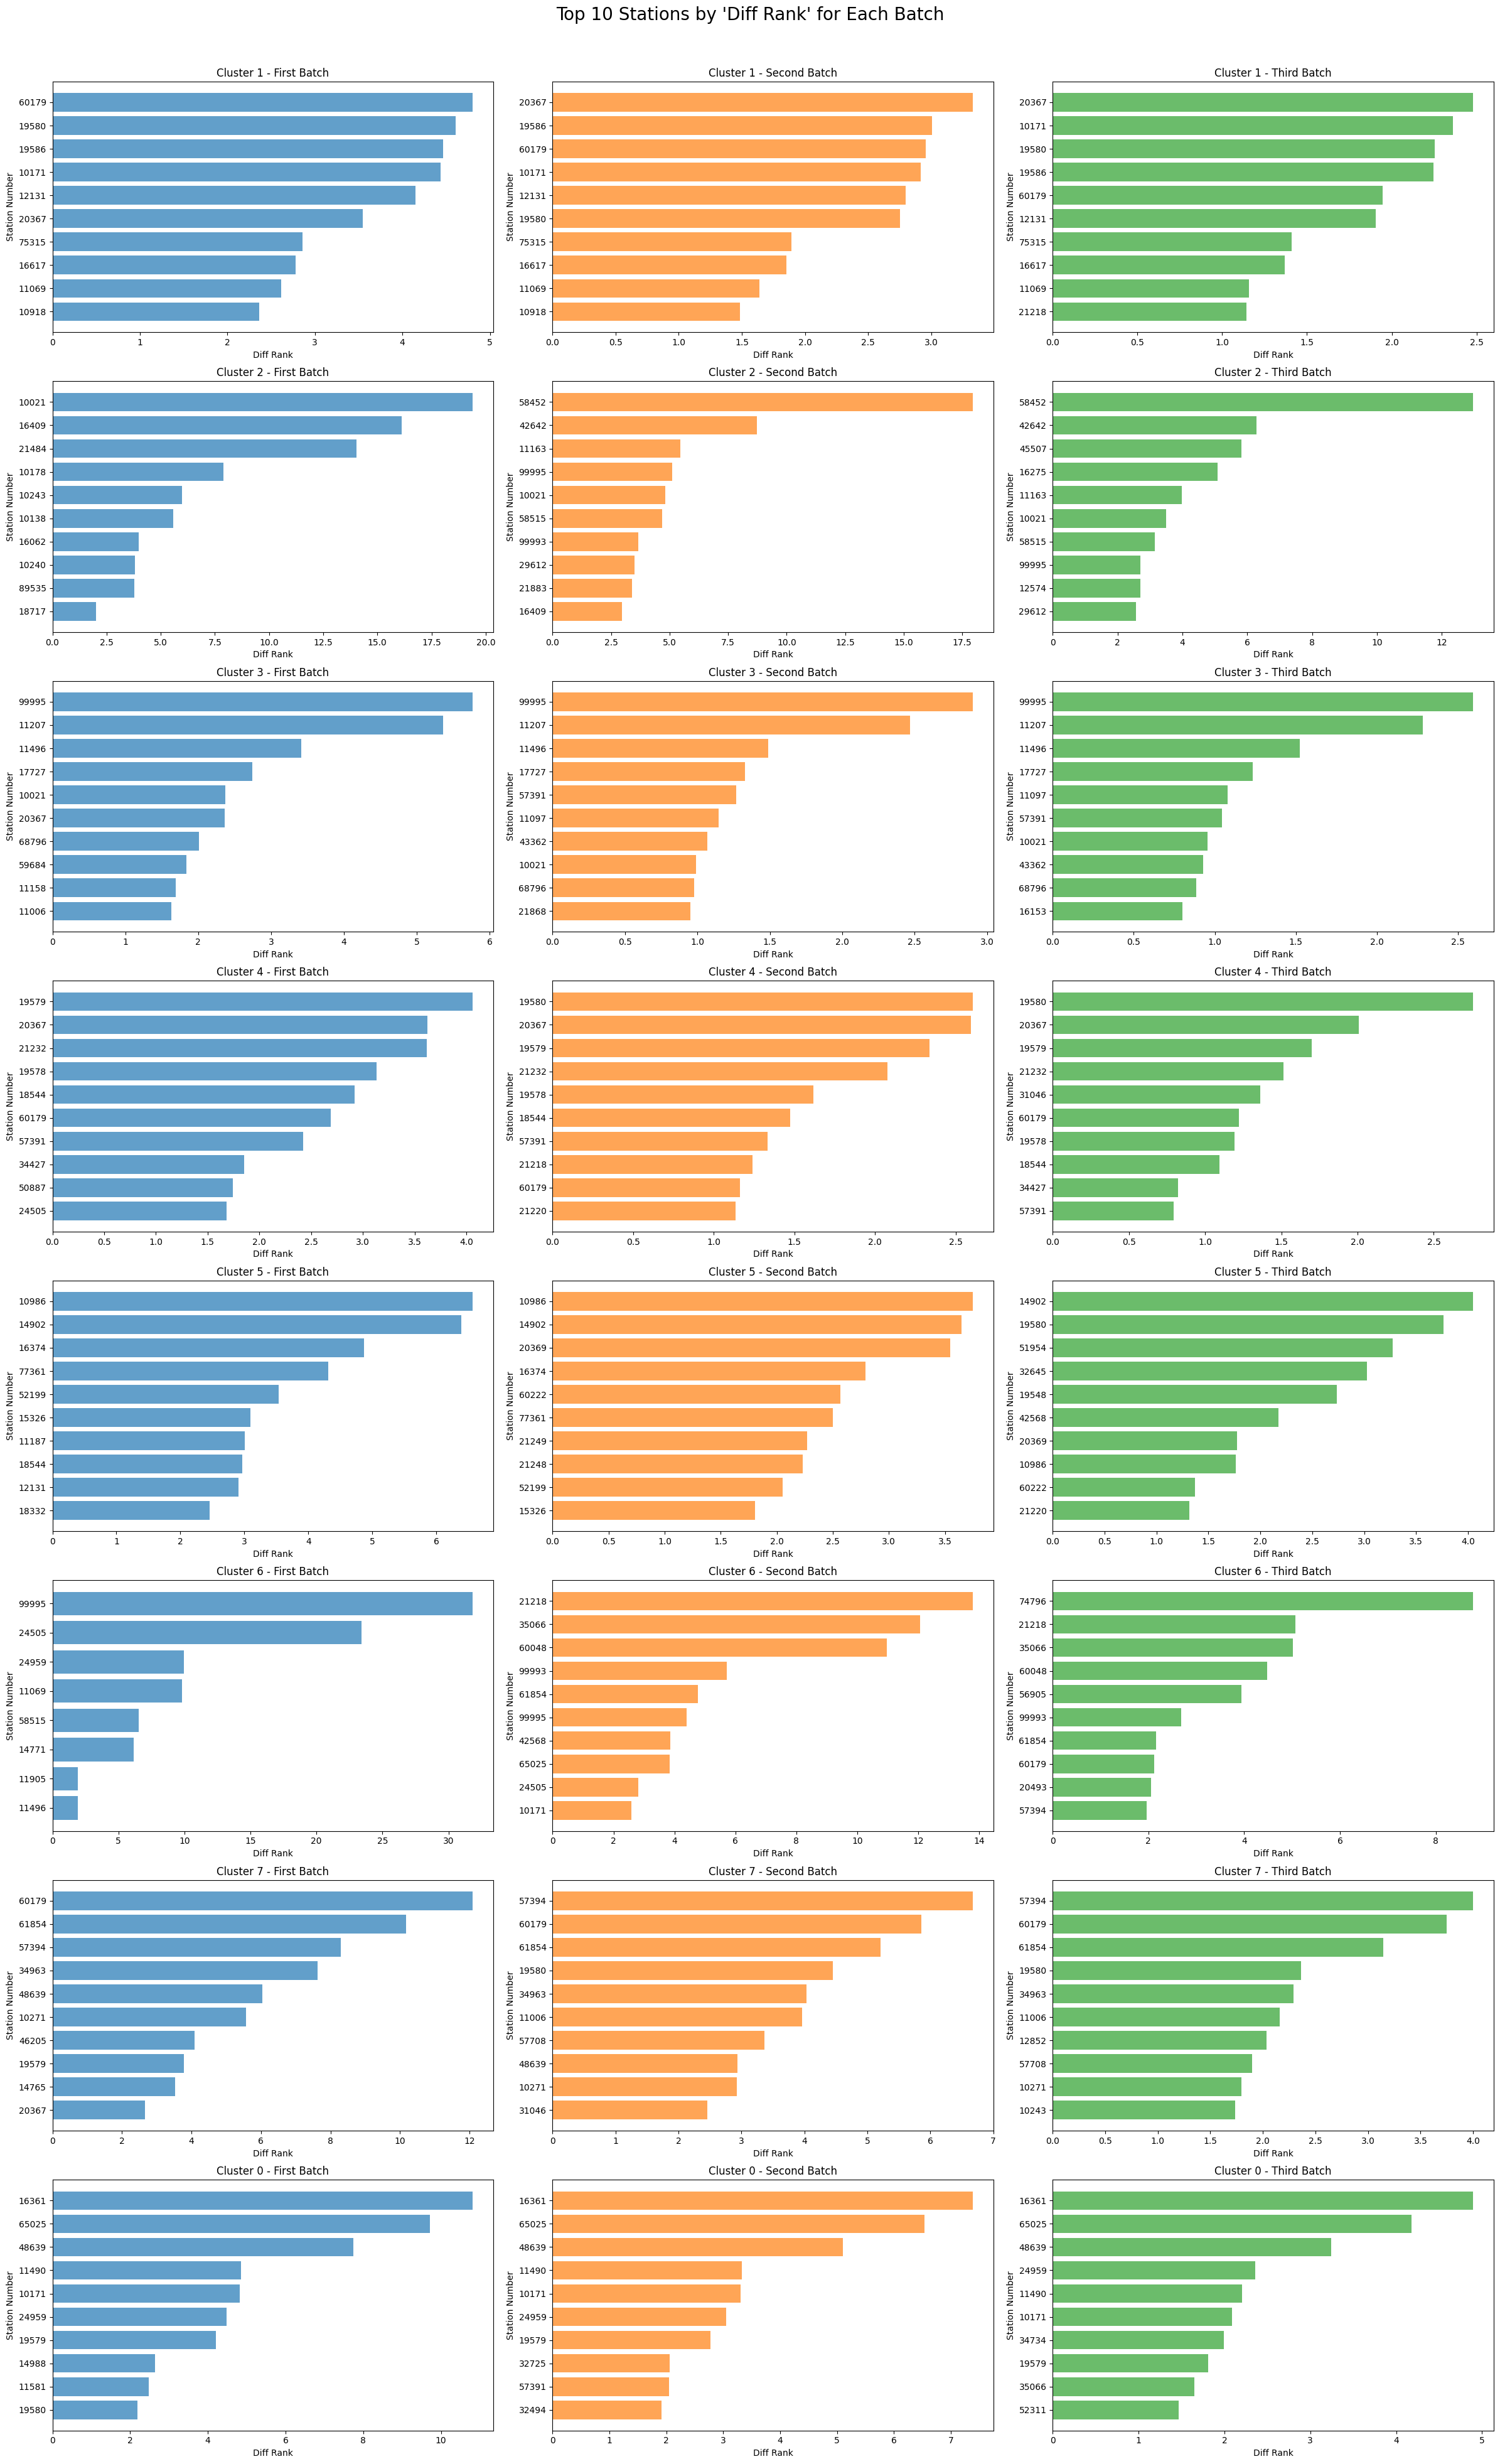

In [0]:
from pyspark.sql import SparkSession, functions as F, Window
import time

# Kafka and Spark Configuration 
SCHEMA = "device_id STRING, event_date INT, event_time INT, station_num STRING, prog_code STRING, household_id STRING"
kafka_server = "kafka.eastus.cloudapp.azure.com:29092" 
topic = "view_data" 
OFFSETS_PER_TRIGGER = 50000

# Create Spark session
spark = SparkSession.builder.appName("StreamingViewingData").getOrCreate() 

# Read Streaming Data from Kafka
streaming_df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_server) \
    .option("subscribe", topic) \
    .option("startingOffsets", "earliest") \
    .option("failOnDataLoss", False) \
    .option("maxOffsetsPerTrigger", OFFSETS_PER_TRIGGER) \
    .load() \
    .select(F.from_csv(F.decode("value", "US-ASCII"), schema=SCHEMA).alias("value")) \
    .select("value.*") 

global_df = None    
results = {}                                                      


# Function to process each batch
def process_batch(batch_df, epoch_id): 
    if (epoch_id >= 3): 
        streaming_query.stop() 
        return 
    # Convert household_id to string if necessary
    batch_df = batch_df.withColumn("household_id", F.col("household_id").cast("long"))
    global global_df
    if global_df is None: 
        global_df = batch_df
    else:
        global_df = global_df.union(batch_df) 
    
    
    # Function to calculate viewing percentages per cluster 
    def add_viewing_counts_percent(input_df):
        joined_df = input_df.join(global_df, on='household_id')
        viewing_counts_per_station = joined_df.groupBy('cluster', 'station_num').agg(F.count("*").alias("view_count"))

        viewing_counts_per_cluster = viewing_counts_per_station.groupBy('cluster').agg(F.sum('view_count').alias('view_count_cluster')) 

        viewing_counts_with_totals = viewing_counts_per_station.join( 
            viewing_counts_per_cluster,
            on='cluster', 
            how='inner' 
        ) 
        viewing_counts_percent = viewing_counts_with_totals.withColumn( 
            'percent_view_count', 
            (F.col('view_count') / F.col('view_count_cluster')) * 100  
        ) 

        return viewing_counts_percent.drop('view_count_cluster', 'view_count') 

    # Calculate percentage viewing for the current batch
    viewing_counts_percent_total = global_df.groupBy('station_num').agg(
        F.count("*").alias("view_count") 
    ).withColumn(
        'percent_view_count_total',
        (F.col('view_count') / F.sum('view_count').over(Window.partitionBy())) * 100
    ).drop('view_count')

    # Add diff_rank calculation
    def add_diff_rank(input_df):
        joined_df = input_df.join(
            viewing_counts_percent_total, 
            on='station_num',
            how='inner'
        )
        df_diff_rank = joined_df.withColumn(
            'diff_rank',
            F.col('percent_view_count') - F.col('percent_view_count_total') 
        )
        return df_diff_rank.drop('percent_view_count', 'percent_view_count_total')

    # Get top 10 stations per cluster based on diff_rank 
    def get_top_10_stations_per_subset(subset_df):
        window_spec = Window.partitionBy("cluster").orderBy(F.desc("diff_rank")) 
        return subset_df.withColumn(
            "row_number", F.row_number().over(window_spec)
        ).filter(F.col('row_number') <= 10).drop('row_number') 

    # Analyze the 7ths subset 
    print(f"trigger {epoch_id}, top-10 highest ’diff rank’ stations per cluster for sevenths_subset") 
    for c in range(8): 
        filtered_sevenths_subset = sevenths_subset.filter(F.col("cluster") == c) 
        sevenths_subset_percent = add_viewing_counts_percent(filtered_sevenths_subset) 
        sevenths_subset_diff_rank = add_diff_rank(sevenths_subset_percent) 
        sevenths_subset_diff_rank_top10 = get_top_10_stations_per_subset(sevenths_subset_diff_rank)
        results[(epoch_id, c)] = sevenths_subset_diff_rank_top10
        sevenths_subset_diff_rank_top10.show(truncate=False) 

# Set up the streaming query to process each batch 
update_streamig_df = streaming_df.withColumn("household_id", F.concat(F.lit("0"), streaming_df["household_id"]))
streaming_query = streaming_df.writeStream \
    .foreachBatch(process_batch) \
    .outputMode("append").start() 

# Run the stream for at least 3 batches/triggers
streaming_query.awaitTermination()  # Adjust the time to ensure at least 3 triggers 



        # ---------------Set up the plot--------------
# fig, axes = plt.subplots(8, 3, figsize=(24, 40))
# fig.suptitle("Top 10 Stations by 'Diff Rank' for Each Batch", fontsize=20)

# colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green 

# for cluster in range(0, 8):
#         first_batch = results[(0, cluster)].toPandas()
#         second_batch = results[(1, cluster)].toPandas()
#         third_batch = results[(2, cluster)].toPandas()


#         first_batch_sorted = first_batch[first_batch['cluster'] == cluster].sort_values('diff_rank', ascending=True)
#         second_batch_sorted = second_batch[second_batch['cluster'] == cluster].sort_values('diff_rank', ascending=True)
#         third_batch_sorted = third_batch[third_batch['cluster'] == cluster].sort_values('diff_rank', ascending=True)
                
#         ax = axes[cluster-1, 0]
#         ax.barh(first_batch_sorted['station_num'], first_batch_sorted['diff_rank'], color=colors[0], alpha=0.7)
#         ax.set_title(f"Cluster {cluster} - First Batch")
#         ax.set_xlabel('Diff Rank')
#         ax.set_ylabel('Station Number')
                
#         ax = axes[cluster-1, 1]
#         ax.barh(second_batch_sorted['station_num'], second_batch_sorted['diff_rank'], color=colors[1], alpha=0.7)
#         ax.set_title(f"Cluster {cluster} - Second Batch")
#         ax.set_xlabel('Diff Rank')
#         ax.set_ylabel('Station Number')  

#         ax = axes[cluster-1, 2]
#         ax.barh(third_batch_sorted['station_num'], third_batch_sorted['diff_rank'], color=colors[2], alpha=0.7)
#         ax.set_title(f"Cluster {cluster} - Third Batch")
#         ax.set_xlabel('Diff Rank')
#         ax.set_ylabel('Station Number')

# plt.tight_layout()
# plt.subplots_adjust(top=0.95)
# plt.show()  

